# 04. Training MLP model

#### This notebook trains an MLP to predict Gurobi runtime based on structural features and param_id.
It supports:
- One-hot encoding for `param_id`
- Train/Val/Test split
- TensorBoard visualization

## Imports

In [1]:
import pandas as pd
import torch
import sys
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

In [2]:
# set up project root path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from src.train_model import MIPDataset, MLPRegressor, load_data, train_loop, evaluate_loop

## Datasets

In [4]:
OUTPUT_CSV = "../data/processed/modeldataset.csv"
FEATURE_COLS = ["VariablesVari.", "BinariesBina.", "IntegersInte.",
                "ContinuousCont.", "ConstraintsCons.", "Nonz.Nonz."]

X_scaled, y = load_data(OUTPUT_CSV, FEATURE_COLS)
dataset = MIPDataset(X_scaled, y)

In [5]:
n = len(dataset)
n_test = int(n * 0.1)
n_val = int(n * 0.1)
n_train = n - n_val - n_test

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(20))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64)
test_loader  = DataLoader(test_set, batch_size=64)

## Training

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPRegressor(input_dim=X_scaled.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.SmoothL1Loss()

model, train_losses, val_losses = train_loop(model, train_loader, val_loader, optimizer, criterion,
                                        epochs=3000, device=device, early_stopping=True, patience=100,
                                        delta=3e-4, save_path="../model/best_model.pt")

[Epoch 01] Train Loss: 2.0348 | Val Loss: 1.7557
[Epoch 02] Train Loss: 1.4606 | Val Loss: 1.1408
[Epoch 03] Train Loss: 1.1005 | Val Loss: 0.9710
[Epoch 04] Train Loss: 1.0394 | Val Loss: 0.9515
[Epoch 05] Train Loss: 1.0233 | Val Loss: 0.9406
[Epoch 06] Train Loss: 1.0065 | Val Loss: 0.9329
[Epoch 07] Train Loss: 1.0013 | Val Loss: 0.9293
[Epoch 08] Train Loss: 1.0021 | Val Loss: 0.9270
[Epoch 09] Train Loss: 0.9970 | Val Loss: 0.9253
[Epoch 10] Train Loss: 0.9953 | Val Loss: 0.9244
[Epoch 11] Train Loss: 0.9867 | Val Loss: 0.9228
[Epoch 12] Train Loss: 0.9892 | Val Loss: 0.9243
[Epoch 13] Train Loss: 0.9950 | Val Loss: 0.9229
[Epoch 14] Train Loss: 0.9880 | Val Loss: 0.9238
[Epoch 15] Train Loss: 0.9956 | Val Loss: 0.9233
[Epoch 16] Train Loss: 0.9843 | Val Loss: 0.9222
[Epoch 17] Train Loss: 0.9819 | Val Loss: 0.9217
[Epoch 18] Train Loss: 0.9806 | Val Loss: 0.9230
[Epoch 19] Train Loss: 0.9783 | Val Loss: 0.9233
[Epoch 20] Train Loss: 0.9837 | Val Loss: 0.9221
[Epoch 21] Train Los

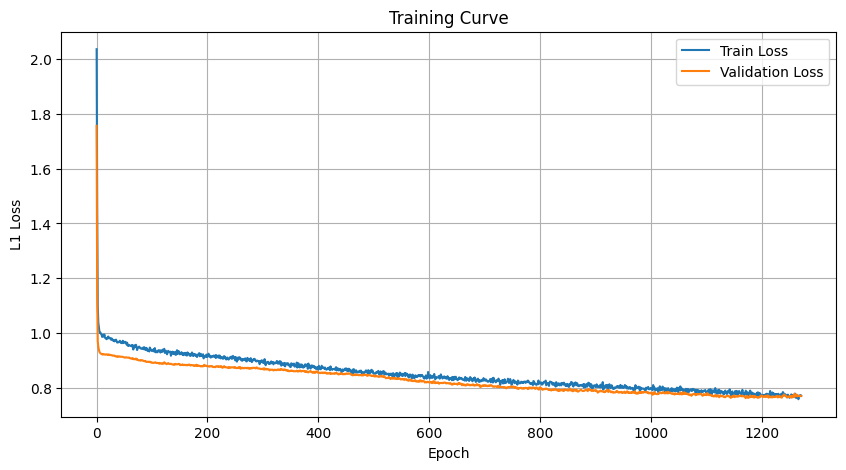

In [7]:
# plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
evaluate_loop(model, test_loader, device=device, label="Test")


 Test Set:
  MAE : 40.69428031050898
  R²  : -0.004171539869697316

Sample Predictions (first 10):
True: 44.04 s | Pred: 41.22 s | Δ = 2.81
True: 58.09 s | Pred: 68.76 s | Δ = 10.67
True: 90.00 s | Pred: 35.16 s | Δ = 54.84
True: 20.47 s | Pred: 15.82 s | Δ = 4.65
True: 90.00 s | Pred: 23.47 s | Δ = 66.54
True: 90.01 s | Pred: 1.95 s | Δ = 88.06
True: 3.56 s | Pred: 18.27 s | Δ = 14.71
True: 4.50 s | Pred: 3.61 s | Δ = 0.89
True: 27.30 s | Pred: 18.71 s | Δ = 8.59
True: 28.37 s | Pred: 32.49 s | Δ = 4.12
